In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import data_reader as dr
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
from tensorflow import keras

In [2]:
data, target = dr.read_data(window=22)
split_index = int(len(data)*0.8)
data.tail()
# target.info()

,Date,Daily_trading_range,Log_Volume_change,Daily_return,Daily_log_return,Index,past_vol
2429,2020-12-23,52.800049,-11.725771,0.009562,0.009517,2759.820068,0.162242
2430,2020-12-24,49.559814,-8.405652,0.017045,0.016901,2806.860107,0.169021
2431,2020-12-28,35.030029,-2.425135,0.000620,0.000620,2808.600098,0.166023
2432,2020-12-29,31.379882,3.955703,0.004241,0.004232,2820.510010,0.164762
2433,2020-12-30,68.859863,2.565210,0.018777,0.018603,2873.469971,0.172738


In [3]:
def data_prep(data, target, split_index, n_ahead=1, window=22):


    data = data.drop(['Daily_return','Date'], axis=1)

    window = window
    n_ahead = n_ahead
    y_values = target
    x_values = data
    print(x_values.info())

    scaler = MinMaxScaler()
    scaled_x = scaler.fit_transform(x_values)
    scaled_y = scaler.fit_transform(y_values)

    trainX = np.array(scaled_x[:split_index])
    testX = np.array(scaled_x[split_index:])
    trainY = np.array(scaled_y[:split_index])
    testY = np.array(scaled_y[split_index:])

    Xtrain = np.array([])
    ytrain = np.array([])
    Xtest = np.array([])
    ytest = np.array([])

    for i in range(window, len(trainX)-n_ahead-window):
        candidate = trainX[i - window:i, :trainX.shape[1]]

        candidate = candidate.reshape(1, candidate.shape[0], candidate.shape[1])
        y_candidate = trainY[i-window:i-window+n_ahead].reshape(1, trainY[i-window:i-window+n_ahead].shape[0], trainY[i:i+n_ahead].shape[1])

        if i==window:
            Xtrain = candidate
            ytrain = y_candidate
            continue

        Xtrain = np.append(Xtrain, candidate, axis=0)
        ytrain = np.append(ytrain, y_candidate, axis=0)
        # ytrain.append(trainY[i:i+n_ahead])

    for i in range(window, len(testX)-n_ahead-window):
        test_candidate = testX[i - window:i, :testX.shape[1]]
        test_candidate = test_candidate.reshape(1, test_candidate.shape[0], test_candidate.shape[1])
        test_y_can = testY[i-window:i-window+n_ahead].reshape(1, testY[i-window:i-window+n_ahead].shape[0], testY[i-window:i-window+n_ahead].shape[1])

        if(i==window):
            Xtest = test_candidate
            ytest = test_y_can
            continue
        Xtest = np.append(Xtest, test_candidate, axis=0)
        ytest = np.append(ytest, test_y_can, axis=0)

        # Xtest.append(test_candidate)
        # ytest.append(testY[i:i+n_ahead])
    # Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
    # Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))
    #
    # Xtest, ytest = (np.array(Xtest), np.array(ytest))
    # Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

    print(Xtrain.shape)
    print(ytrain.shape)
    print("-----")
    print(Xtest.shape)
    print(ytest.shape)
    return Xtrain, ytrain, Xtest, ytest, scaler


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2434 entries, 0 to 2433
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2434 non-null   object 
 1   Daily_trading_range  2434 non-null   float64
 2   Log_Volume_change    2434 non-null   float64
 3   Daily_return         2434 non-null   float64
 4   Daily_log_return     2434 non-null   float64
 5   Index                2434 non-null   float64
 6   past_vol             2434 non-null   float64
dtypes: float64(6), object(1)
memory usage: 133.2+ KB


In [5]:
Xtrain, ytrain, Xtest, ytest, scaler = data_prep(data, target, split_index=split_index, window=22, n_ahead=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2434 entries, 0 to 2433
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Daily_trading_range  2434 non-null   float64
 1   Log_Volume_change    2434 non-null   float64
 2   Daily_log_return     2434 non-null   float64
 3   Index                2434 non-null   float64
 4   past_vol             2434 non-null   float64
dtypes: float64(5)
memory usage: 95.2 KB
None
(1902, 22, 5)
(1902, 1, 1)
-----
(442, 22, 5)
(442, 1, 1)


In [6]:
print(Xtrain.shape)
print(ytrain.shape)
print("-----")
print(Xtest.shape)
print(ytest.shape)

(1902, 22, 5)
(1902, 1, 1)
-----
(442, 22, 5)
(442, 1, 1)


In [7]:
def create_model(neurons1=10, neurons2=10, neurons3=10, lr=0.001, activation='tanh'):
    model = Sequential()
    model.add(Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
    model.add(Dense(neurons1,activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(neurons2,activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(neurons3,activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    adam = Adam(learning_rate=lr)
    model.compile(loss='mse', optimizer=adam)
    return model
    # model.fit(Xtrain, ytrain, epochs=150, batch_size=16, validation_split=0.1, shuffle=False)

In [8]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier


In [9]:
regressor = KerasRegressor(build_fn=create_model, epochs=50, batch_size=16, verbose=0)

In [10]:
tscv = TimeSeriesSplit(n_splits=3)



In [10]:
params = dict(neurons1=[64,32,20,10],
              neurons2=[64,32,20,10],
              neurons3=[64,32,20,10],
              lr=[0.001,0.0005],
              epochs=[50,100])
grid = GridSearchCV(estimator=regressor, param_grid=params, verbose=10)
grid_result = grid.fit(Xtrain, ytrain)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5; 1/256] START epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 1/5; 1/256] END epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   7.7s
[CV 2/5; 1/256] START epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 2/5; 1/256] END epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   6.3s
[CV 3/5; 1/256] START epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 3/5; 1/256] END epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   6.2s
[CV 4/5; 1/256] START epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 4/5; 1/256] END epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   6.4s
[CV 5/5; 1/256] START epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 5/5; 1/256] END epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   6.2s
[CV 1/5; 2/256] START epochs=50, lr=

In [11]:
print('Best score s: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))
bestParams = grid_result.best_params_

Best score s: -0.00033921411813935264 using {'epochs': 100, 'lr': 0.0005, 'neurons1': 20, 'neurons2': 64, 'neurons3': 64}


## Gridsearch result (ANN)
activation: tanh
batch_size: 16
epochs: 100
learning rate: 0.001,
neuron1 64
neuron2 64
neuron3 16

In [115]:
params = dict(neurons1=[64,32,16],
              neurons2=[64,32,16],
              neurons3=[64,32,16],
              batch_size=[32,16],
              lr=[0.001,0.005],
              epochs=[50,100]
              )
grid2 = GridSearchCV(estimator=regressor, param_grid=params, verbose=10)
grid_result2 = grid2.fit(Xtrain, ytrain)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5; 1/216] START batch_size=32, epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 1/5; 1/216] END batch_size=32, epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   4.6s
[CV 2/5; 1/216] START batch_size=32, epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 2/5; 1/216] END batch_size=32, epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   4.1s
[CV 3/5; 1/216] START batch_size=32, epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 3/5; 1/216] END batch_size=32, epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   4.2s
[CV 4/5; 1/216] START batch_size=32, epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 4/5; 1/216] END batch_size=32, epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   4.3s
[CV 5/5; 1/216] START batch_size=32, epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64


In [119]:
print('Best score s: {} using {}'.format(grid_result2.best_score_, grid_result2.best_params_))
bestParams = grid_result2.best_params_

Best score s: -0.003715799341443926 using {'batch_size': 16, 'epochs': 50, 'lr': 0.005, 'neurons1': 16, 'neurons2': 64, 'neurons3': 32}


In [12]:
model = create_model(neurons1=20,neurons2=64, neurons3=64, lr=0.0005)
model_fit = model.fit(Xtrain, ytrain, batch_size=32, epochs=100, shuffle=False,validation_data=(Xtest,ytest))
forecast = model.predict(Xtest)

Epoch 1/100
60/60 [==============================] - 1s 9ms/step - loss: 0.2532 - val_loss: 0.0697
Epoch 2/100
60/60 [==============================] - 0s 3ms/step - loss: 0.0685 - val_loss: 0.0177
Epoch 3/100
60/60 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0175
Epoch 4/100
60/60 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0152
Epoch 5/100
60/60 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0130

In [70]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 88)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                5696      
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_31 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)              

In [13]:
forecast = forecast.mean(axis=1).reshape(len(forecast),1)
ytest = ytest.mean(axis=1).reshape(len(ytest),1)

print(forecast.shape)
print(ytest.shape)

(442, 1)
(442, 1)


In [14]:
rev_forecast = scaler.inverse_transform(forecast)
rev_ytest = scaler.inverse_transform(ytest)

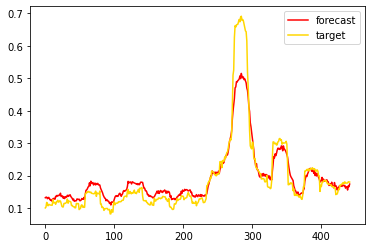

In [15]:
plt.plot(rev_forecast, color='red', label='forecast')
plt.plot(rev_ytest, color='gold', label='target')
plt.legend()
# plt.savefig("images/single_layer_model_pred.png")

plt.show()

In [16]:
testScore = mean_squared_error(y_true=ytest, y_pred=forecast)
print("test Score: {score} MSE".format(score=testScore))
root_testScore = mean_squared_error(y_true=ytest, y_pred=forecast, squared=False)
print("test Score: {score} RMSE".format(score=root_testScore))
mape = mean_absolute_percentage_error(y_pred=rev_forecast, y_true=rev_ytest)
print("test Score: {score} MAPE".format(score=mape))
mae = mean_absolute_error(y_pred=rev_forecast, y_true=rev_ytest)
print("test Score: {score} MAE".format(score=mae))

test Score: 0.004480193260562905 MSE
test Score: 0.06693424579811821 RMSE
test Score: 0.1398000156072129 MAPE
test Score: 0.02592271307896511 MAE


In [50]:
model.save

<bound method Model.save of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f31cc228700>>